## Курсовая работа
Выполнил: Морозов Артем Борисович, группа М8О-109СВ-24

Датасет: [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

## Информация о датасете

Датасет содержит медицинские и демографические данные пациентов, собранные с целью прогнозирования риска инсульта. Данные включают информацию о здоровье, образе жизни и социально-экономических факторах. Набор данных был подготовлен для задачи бинарной классификации — определения вероятности возникновения инсульта у пациента на основе наблюдаемых признаков.

Датасет состоит из следующих колонок:

| Поле               | Описание                                                               |
| ------------------ | ---------------------------------------------------------------------- |
| `gender`           | Пол пациента (Male, Female, Other) |
| `age`              | Возраст пациента (число) |
| `hypertension`     | Наличие гипертонии (0 — нет, 1 — да) |
| `heart_disease`    | Наличие сердечных заболеваний (0 — нет, 1 — да) |
| `ever_married`     | Факт брака (Yes / No) |
| `work_type`        | Тип занятости (Private, Self-employed, Govt_job, Children, Never_worked) |
| `Residence_type`   | Тип места проживания (Urban, Rural) |
| `avg_glucose_level`| Средний уровень глюкозы в крови (число)|
| `bmi`              | Индекс массы тела (число) |
| `smoking_status`   | Статус курения (formerly smoked, never smoked, smokes, Unknown) |
| `stroke`           | Целевая переменная: 1 — был инсульт, 0 — не было |

Датасет используется для задачи бинарной классификации — предсказания наличия риска инсульта.



## Импорт необходимых библиотек

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import time
import shap
import lime
import lime.lime_tabular
import numpy as np

## Загрузим датасет

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

## Выполним первичный анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [ ]:
# Проверка наличия пропусков
print(df.isnull().sum())

# Заполняем пропуски в bmi средним значением
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


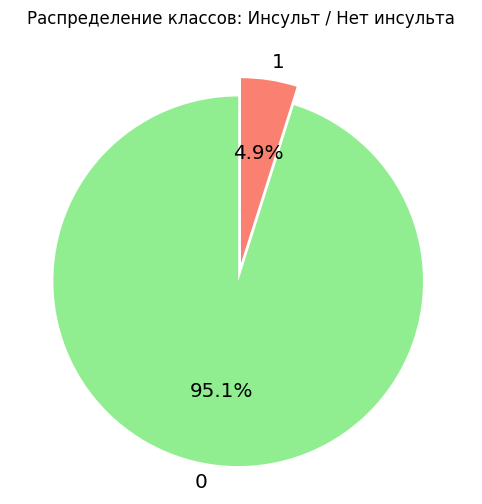

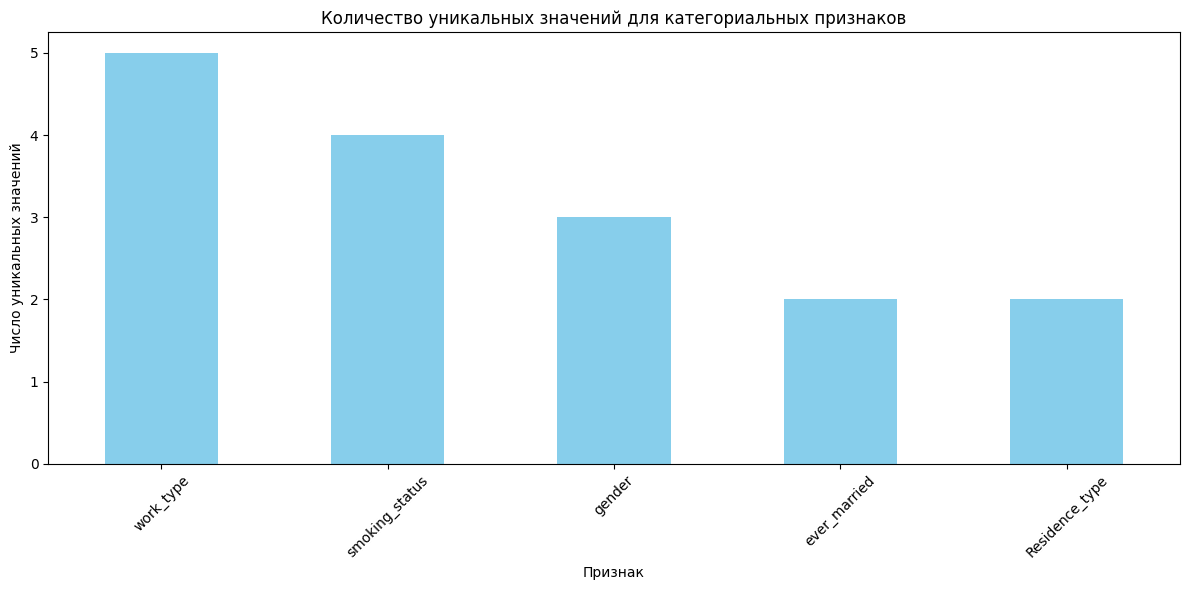

In [ ]:
def plot_stroke_distribution(target_series):
    plt.figure(figsize=(8, 6))
    target_series.value_counts().plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightgreen', 'salmon'],
        explode=(0.1, 0),
        textprops={'size': 'x-large'}
    )
    plt.title('Распределение классов: Инсульт / Нет инсульта')
    plt.ylabel('')
    plt.show()

def plot_categorical_unique(dataframe, cat_columns):
    unique_counts = dataframe[cat_columns].nunique()
    plt.figure(figsize=(12, 6))
    unique_counts.sort_values(ascending=False).plot(
        kind='bar',
        color='skyblue'
    )
    plt.title('Количество уникальных значений для категориальных признаков')
    plt.xlabel('Признак')
    plt.ylabel('Число уникальных значений')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

plot_stroke_distribution(df['stroke'])
plot_categorical_unique(df, categorical_features)

In [ ]:
df.dropna(inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(exclude='object').columns
display(categorical_cols)
display(numerical_cols)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke'],
      dtype='object')

In [ ]:
corr = df[numerical_cols].corr()
# смотрим топ-5 пары числовых признаков, которые сильнее всего коррелируют между собой
corr.unstack().sort_values(ascending=False).drop_duplicates().head(10)

id                 id                   1.000000
bmi                age                  0.325942
age                hypertension         0.276398
                   heart_disease        0.263796
                   stroke               0.245257
                   avg_glucose_level    0.238171
avg_glucose_level  hypertension         0.174474
                   bmi                  0.168751
                   heart_disease        0.161857
hypertension       bmi                  0.160189
dtype: float64

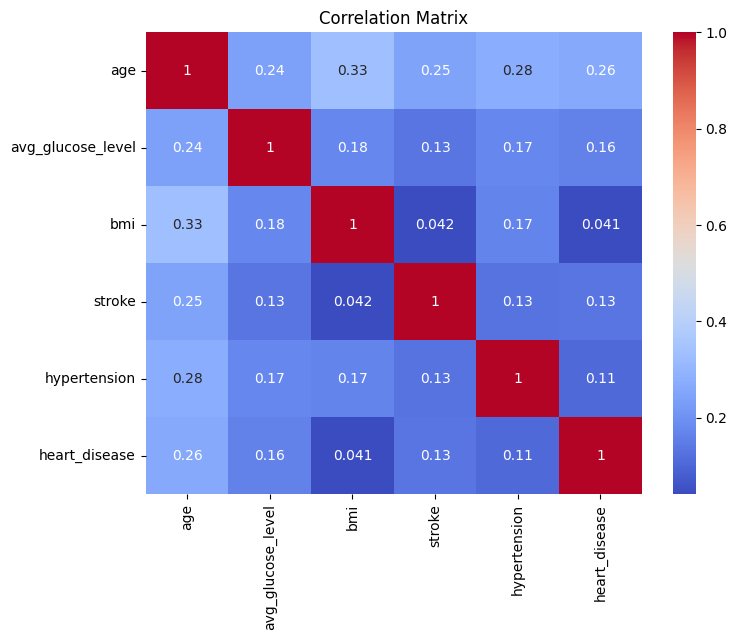

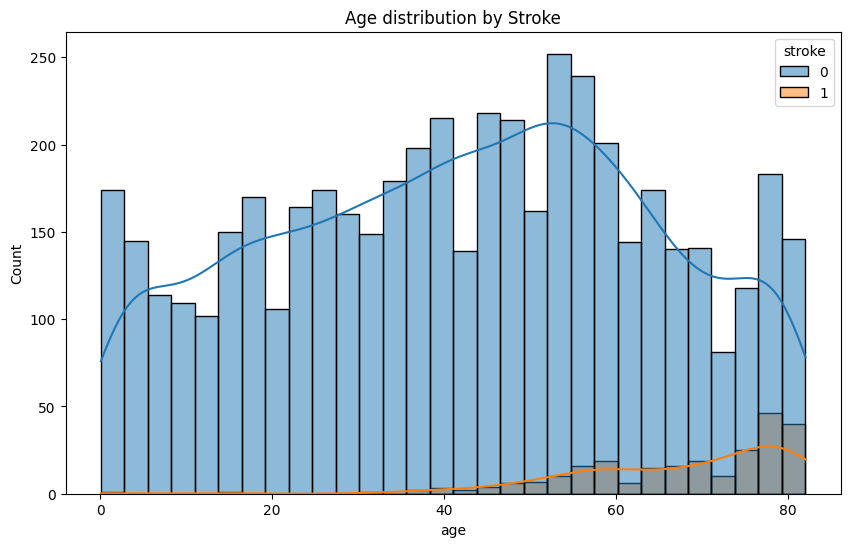

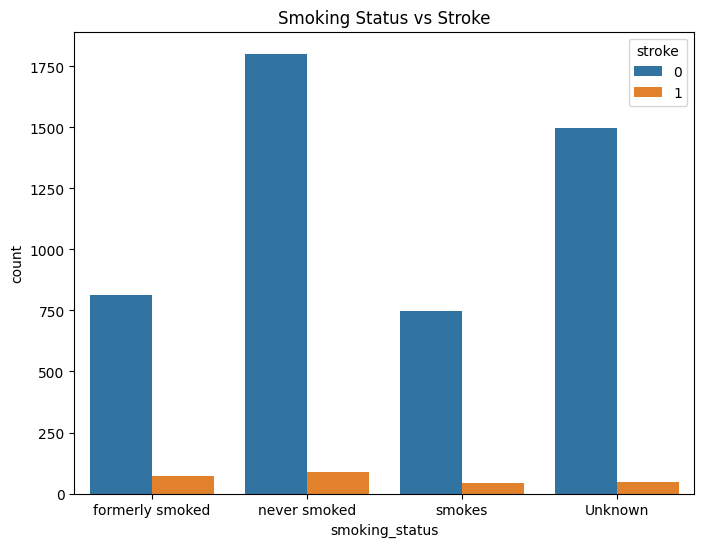

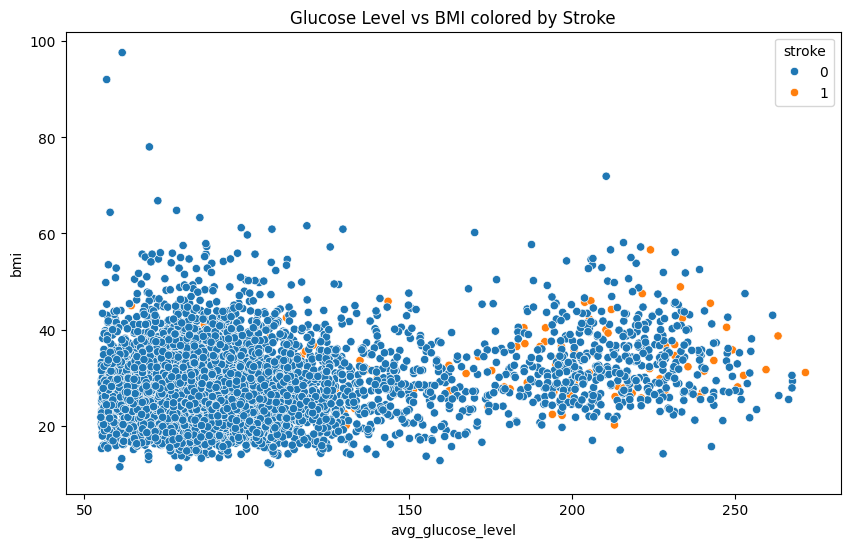

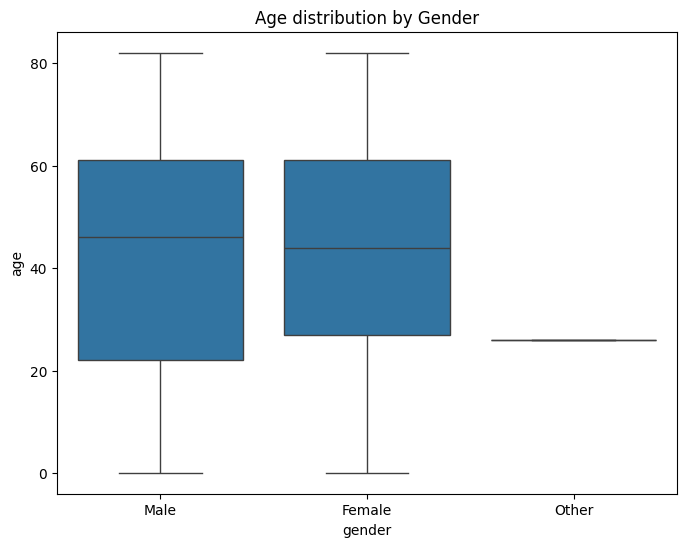

In [54]:
# 1. Корреляция для числовых признаков
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke', 'hypertension', 'heart_disease']
corr = df[numeric_cols].corr()

# 2. Тепловая карта корреляций
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Распределение по возрасту и наличие инсульта
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title('Age distribution by Stroke')
plt.show()

# 4. Влияние курения на инсульт (счётчики)
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='smoking_status', hue='stroke')
plt.title('Smoking Status vs Stroke')
plt.show()

# 5. Диаграмма рассеяния avg_glucose_level и bmi с оттенком по инсульту
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='avg_glucose_level', y='bmi', hue='stroke')
plt.title('Glucose Level vs BMI colored by Stroke')
plt.show()

# 6. Boxplot для возраста по полу
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='gender', y='age')
plt.title('Age distribution by Gender')
plt.show()

## Обучение модели

In [ ]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Обучение завершено за {:.2f} секунд".format(end_time - start_time))
print("Лучшая комбинация параметров:", grid_search.best_params_)
print("Accuracy на тестовой выборке: {:.4f}".format(accuracy))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Обучение завершено за 23.53 секунд
Лучшая комбинация параметров: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Accuracy на тестовой выборке: 0.9393


## Посмотрим на метрики для класса 0 (нет инсульта)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred)

precision_0 = precision[0]
recall_0 = recall[0]
fbeta_score_0 = fbeta_score[0]
print("Precision для класса 0:", precision_0)
print("Recall для класса 0:", recall_0)
print("F1 для класса 0:", fbeta_score_0)

Precision для класса 0: 0.9393346379647749
Recall для класса 0: 1.0
F1 для класса 0: 0.9687184661957619


C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Пояснение по строкам:

| Показатель    | Значение                                                                                                                       |
| ------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **precision** | Точность — доля правильных положительных предсказаний среди всех положительных предсказаний (важна при ограниченных ресурсах). |
| **recall**    | Полнота — доля правильно найденных положительных объектов среди всех фактически положительных.                                 |
| **f1-score**  | Гармоническое среднее между precision и recall. Хорошая сводная метрика.                                                       |

Класс 0 — "нет инсульта"

Precision = 0.94 → Из всех случаев, когда модель предсказала "нет инсульта", в 94% случаях это действительно так.

Recall = 1.0 → Модель нашла ВСЕ реальные случаи отсутствия инсульта.

F1-score = 0.97 → Общая эффективность модели на этом классе очень высока.

## Посмотрим на метрики для класса 1 (есть инсульт)

In [ ]:
precision_1 = precision[1]
recall_1 = recall[1]
fbeta_score_1 = fbeta_score[1]
print("Precision для класса 1:", precision_1)
print("Recall для класса 1:", recall_1)
print("F1 для класса 1:", fbeta_score_1)

Precision для класса 1: 0.7455642114568314
Recall для класса 1: 0.7344445312334875
F1 для класса 1: 0.7132113578331564


Класс 1 — "есть инсульт"

Precision = 0.75 → Из всех случаев, когда модель сказала "инсульт", в 75% случаях это верно.

Recall = 0.73 → Модель смогла обнаружить 73% реальных случаев инсульта.

F1-score = 0.71 → Эффективность ниже, чем у класса 0, но всё ещё довольно неплохо.

Вероятнее всего, модель лучше распознает класс 0 из-за того, что представителей класса 0 больше, чем представителей класса 1.

## SHAP

In [19]:
X_train = X_train.astype({col: int for col in X_train.select_dtypes(include='bool').columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes(include='bool').columns})

In [22]:
explainer = shap.Explainer(best_model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

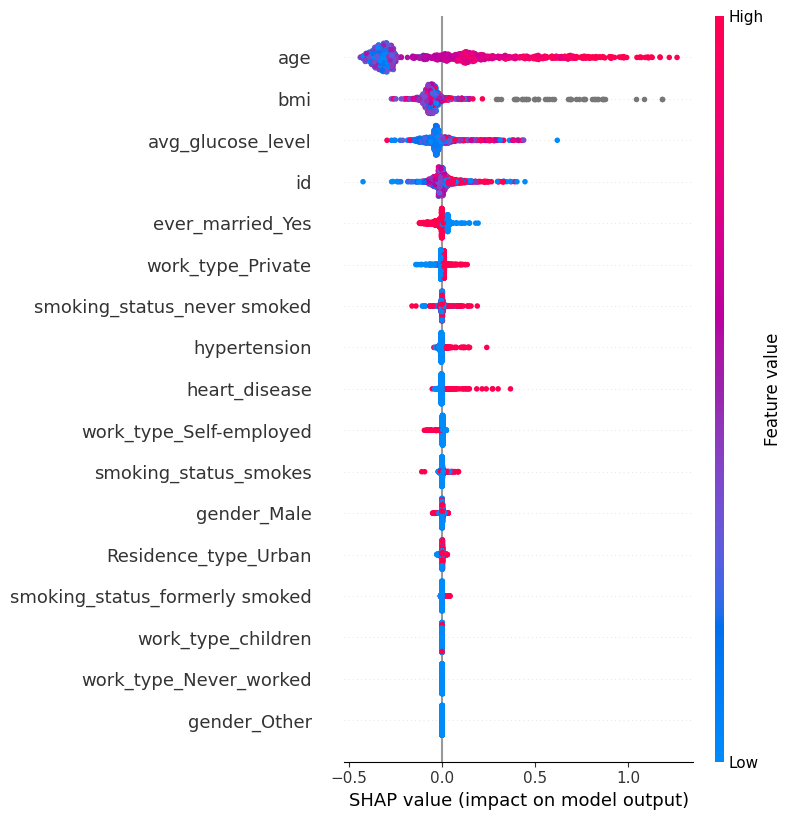

In [23]:
shap.summary_plot(shap_values, X_test)

## Что показывает график
По вертикали (ось Y) — признаки, отсортированные по среднему влиянию на модель (самые важные — сверху).

По горизонтали (ось X) — SHAP value, то есть насколько сильно данный признак влияет на предсказание (влево — уменьшает вероятность положительного класса, вправо — увеличивает).

Цвет — значение признака (🔵 — низкое, 🔴 — высокое).

## Интерпретация признаков
* age — Очень высокое влияние. Чем старше человек (🔴), тем сильнее увеличивается вероятность положительного класса (сдвиг вправо).

* bmi — Значимое влияние. Высокие значения ИМТ (🔴) немного увеличивают вероятность, низкие (🔵) — уменьшают.

* avg_glucose_level — Значимое. Высокий уровень глюкозы (🔴) — тоже ведёт к увеличению вероятности положительного класса.

* ever_married_Yes — Умеренное влияние: женатые/замужние чаще демонстрируют сдвиг вправо.

* work_type_Private — Незначительно влияет.

* smoking_status_never smoked — Влияет: некурящие чаще сдвигают модель влево.

* hypertension и heart_disease — Умеренное влияние, особенно при наличии заболеваний (🔴) — вероятность положительного класса растёт.

* gender_Male, Residence_type_Urban, work_type_Self-employed — Влияние слабое, но немного присутствует.

* smoking_status_smokes — Может немного сдвигать модель вправо.

Оставшиеся признаки (gender_Other, work_type_Never_worked, etc.) — Практически не влияют на предсказание.

## LIME

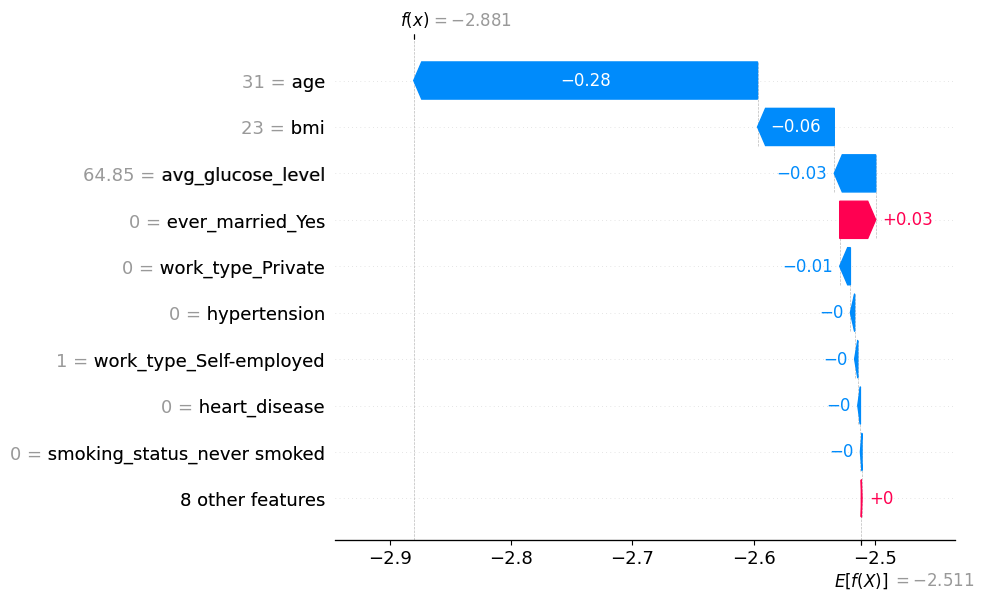

In [24]:
# Индивидуальное объяснение для одного объекта (например, первого)
shap.plots.waterfall(shap_values[0])

In [26]:
shap_values[0]

.values =
array([ 0.00126549, -0.2839223 , -0.00348655, -0.0021823 , -0.03421391,
       -0.06335876,  0.00106486,  0.        ,  0.02975103,  0.        ,
       -0.0088357 , -0.00260287,  0.        , -0.00043696, -0.00052854,
       -0.00132834, -0.00077417])

.base_values =
np.float64(-2.5110307898853277)

.data =
array([4.0041e+04, 3.1000e+01, 0.0000e+00, 0.0000e+00, 6.4850e+01,
       2.3000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [52]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Stroke', 'Stroke'],
    mode='classification'
)

def predict_fn_lime(x):
    return best_model.predict_proba(x)

data_row = X_test.iloc[0].values
exp = explainer.explain_instance(data_row=data_row, predict_fn=predict_fn_lime)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Цель предсказания:
Модель предсказывает вероятность инсульта (Stroke) у одного человека.

* Вероятность "No Stroke" (нет инсульта): 0.99 → модель уверена, что инсульта не будет.

* Вероятность "Stroke": 0.01 → очень малая вероятность инсульта.

## Интерпретация по частям
Столбец "No Stroke" (слева):

Это признаки, которые способствуют отсутствию инсульта, и их влияние положительное на предсказание "No Stroke".

* 25.00 < age <= 45.00: возраст 31 год — довольно молодой, снижает риск (вклад ~0.05).

* hypertension = 0.0: нет гипертонии → снижает риск (вклад ~0.04).

* heart_disease = 0.0: нет сердечных болезней → снижает риск.

* work_type_Never_worked = 0.0: человек работал, что может быть индикатором хорошего состояния.

* avg_glucose_level ≈ 64.85: низкий уровень глюкозы — тоже положительный фактор.

Столбец "Stroke" (справа):

Это признаки, которые слегка увеличивают вероятность инсульта, но их влияние в этом случае минимально.

* work_type_children <= ..., ever_married_Yes <= ..., Residence_type_Urban, smoking_status_never smoked: все они в данном случае не играют существенной роли.

* Все значения этих признаков — 0.0, т.е. они отсутствуют, и их вклад очень незначительный.

## Анализ конкретного пациента
Таблица справа: "Feature — Value"

Показывает значения признаков для этой конкретной строки

| Feature                 | Value  | Значение                                   |
|-------------------------|--------|--------------------------------------------|
| age                     | 31.0   | Молодой возраст                            |
| hypertension            | 0.0    | Нет гипертонии                            |
| heart_disease           | 0.0    | Нет сердечных заболеваний                  |
| avg_glucose_level       | 64.85  | Низкий уровень глюкозы                     |
| work_type_children      | 0.0    | Не ребёнок                                |
| ever_married_Yes        | 0.0    | Не был(а) в браке                         |
| Residence_type_Urban    | 0.0    | Живёт в сельской местности                  |
| smoking_status_smokes   | 0.0    | Не курит                                  |
| smoking_status_never smoked | 0.0    | Тоже 0.00 (возможно: "unknown" в one-hot) |

## Общий вывод

Модель считает, что риск инсульта очень низкий (1%). 

Почему:

* Пациент молодой.

* Нет гипертонии и сердечно-сосудистых заболеваний.

* Уровень глюкозы в норме.

* Курение и другие факторы риска — отсутствуют.

Поэтому LIME показывает, что все ключевые признаки говорят в пользу "No Stroke", и это объяснение модели подтверждает логичность её поведения.

## Сравнение SHAP и Lime

###  LIME:

* Подсветил положительно влияющие признаки — молодой возраст, нормальное давление, здоровье сердца, низкий уровень глюкозы.
* Подсветил Незначительные отрицательные влияния — семейное положение, тип занятости, статус курения.

Вывод: модель очень уверена, что инсульта не будет.

### SHAP:

Самые влиятельные признаки (влияют на предсказание инсульта в целом):

* age — чем старше, тем выше риск (розовый справа).

* bmi — тоже важен: высокий ИМТ повышает вероятность инсульта.

* avg_glucose_level — влияет, особенно при высоких значениях.

* hypertension, heart_disease — также вносят вклад при наличии (синий цвет — 0 → понижение риска, розовый — 1 → повышение).

Малозначимые признаки: gender, work_type_children, gender_Other почти не влияют на итог.

## Итог работы

По результатам интерпретации модели с помощью методов SHAP и LIME можно сделать следующий вывод:

Модель предсказала, что риск инсульта у пациента крайне мал. Ключевыми факторами, снизившими риск, стали молодой возраст, отсутствие гипертонии и сердечных заболеваний, а также нормальные значения глюкозы и индекса массы тела. Несмотря на наличие потенциально отрицательных факторов (например, неженатость или отсутствие постоянной занятости), их вклад оказался незначительным.

SHAP и LIME пришли к согласованному выводу, подтвердив значимость одних и тех же признаков: возраст, артериальное давление, здоровье сердца и глюкоза. SHAP дал глобальное подтверждение важности этих признаков, а LIME — локальное объяснение для конкретного пациента.